In [1]:
#File Extraction, Linear Algebra and Visualization Libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 10)
import gc
#Machine Learning Libraries
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, Input, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#transfer learning Model 
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
print('Classes that are to be predicted', os.listdir('../input/land-classification/Test data'))

Classes that are to be predicted ['natur', 'housing', 'industrial', 'farming']


The shape of our original image is (720, 720, 3)


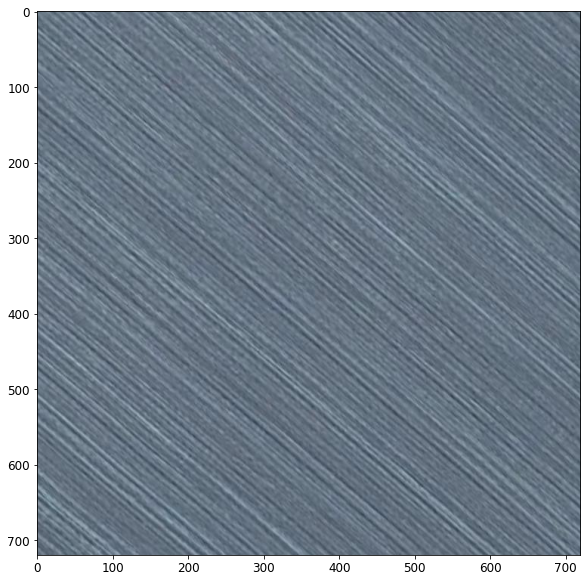

The shape of our resized image is (150, 150, 3)


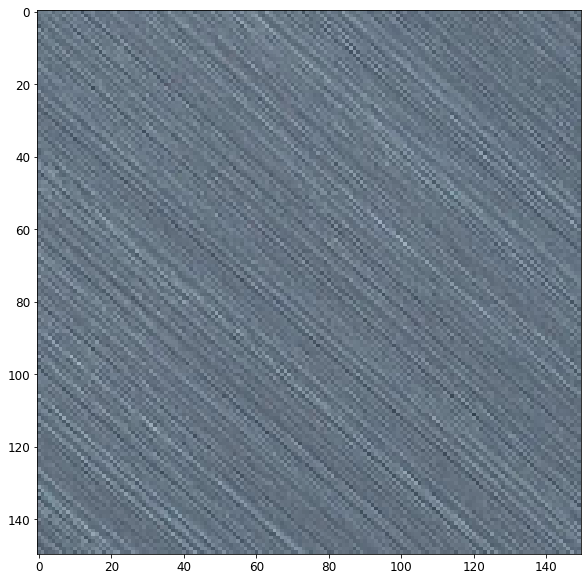

In [3]:
DATADIR = '../input/land-classification/Test data'
CATEGORIES = ['farming','housing','industrial','natur']

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        print('The shape of our original image is', (img_array.shape))
        plt.imshow(img_array)
        plt.show()
        break
    break

IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
print('The shape of our resized image is', (new_array.shape))
plt.imshow(new_array, cmap='gray')
plt.show()

## Creating Data

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
                if category == 'industrialk':   
                    plt.imshow(new_array)
                    plt.show()
            except Exception as e:
                pass
create_training_data()
print("The total images in our training data is",len(training_data))

The total images in our training data is 6997


In [5]:
random.shuffle(training_data)

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print('X Shape -', np.array(X).shape)
print('y Shape -', np.array(y).shape)

X Shape - (6997, 150, 150, 3)
y Shape - (6997,)


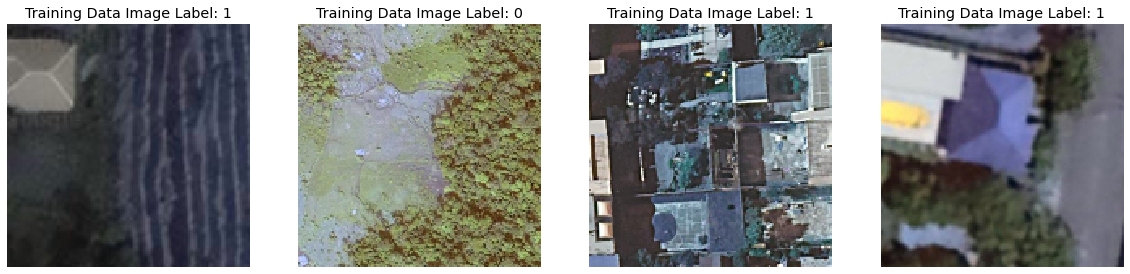

In [6]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,15))
for ax, image, label in zip(axes, X, (y)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training Data Image Label: {label}")  

In [7]:
fig = px.histogram(x=y, template='simple_white', color = y, 
                   labels={'color':"Label"},
                   title='Image Labels Countplot')

fig.update_layout(xaxis_title="Image Labels",yaxis_title=" Count", bargap=0.1)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'], tickvals=[0,1,2,3])

fig.show()

In [8]:
print('{} are the various unique classes in our y.'.format( np.unique(y)))

[0 1 2 3] are the various unique classes in our y.


## VGG16 Implementation and Evaluation

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

Since we have only 4 classes, we are going to accordingly change the input and the output layers only keeping the remaining model architecture the same.

In [9]:
IMAGE_SIZE = [150,150]
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2022-09-19 14:54:16.717641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 14:54:16.721801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 14:54:16.722510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 14:54:16.724079: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
#Ensuring we don't train the layers in between
for layer in vgg16.layers:
    layer.trainable = False

In [11]:
#Scaling the Data
X= X/255

### Building the output and input layer for our use case

In [12]:
#Flattening the Output Layer
OutputLayer = Flatten()(vgg16.output)
#Adding the Output layer
prediction = Dense(4, activation='softmax')(OutputLayer)
#Defining the model and the output and the input layers
pretrainedmodel = Model(inputs=vgg16.input, outputs=prediction)

In [13]:
pretrainedmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Setting Learning Rate Scheduling and EarlyStopping callbacks for VGG16 model

In [14]:
initial_learning_rate = 0.1

lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
pretrainedmodel.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy' ])

## Training VGG16

In [16]:
history = pretrainedmodel.fit(X,y,epochs=100,batch_size = 500, validation_split=0.2,callbacks= callback)

2022-09-19 14:54:22.627428: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1511190000 exceeds 10% of free system memory.
2022-09-19 14:54:24.329404: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1511190000 exceeds 10% of free system memory.
2022-09-19 14:54:25.589717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-19 14:54:27.334513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 48s 2s/step - loss: 35.3857 - accuracy: 0.4947 - val_loss: 4.8909 - val_accuracy: 0.8493
Epoch 2/100
12/12 [==============================] - 7s 573ms/step - loss: 6.3858 - accuracy: 0.8624 - val_loss: 6.2064 - val_accuracy: 0.8700
Epoch 3/100
12/12 [==============================] - 7s 571ms/step - loss: 3.4582 - accuracy: 0.9105 - val_loss: 4.7845 - val_accuracy: 0.8779
Epoch 4/100
12/12 [==============================] - 7s 576ms/step - loss: 2.3807 - accuracy: 0.9323 - val_loss: 3.3838 - val_accuracy: 0.9036
Epoch 5/100
12/12 [==============================] - 7s 571ms/step - loss: 1.8464 - accuracy: 0.9498 - val_loss: 2.8555 - val_accuracy: 0.8993
Epoch 6/100
12/12 [==============================] - 7s 574ms/step - loss: 1.2970 - accuracy: 0.9544 - val_loss: 2.6802 - val_accuracy: 0.9043
Epoch 7/100
12/12 [==============================] - 7s 572ms/step - loss: 0.9527 - accuracy: 0.9669 - val_loss: 2.3068 - val_accuracy: 0.9157
Epoch 8/100


In [17]:
fig = px.line(x = range(len(history.history['accuracy'])),
              y=history.history['accuracy'], 
              template='simple_white',
              color_discrete_sequence=["steelblue"],
              labels = {'x': 'Epochs', 'y':'Accuracy'},
              title = 'VGG16 Training Accuracy Plot', 
              #text=[ '%.3f' % elem for elem in history.history['accuracy'] ],
              markers=True)
fig.update_layout(xaxis_title="Epochs", yaxis_title=" Accuracy")
fig.update_traces(textposition="top center")

#2nd Plot
fig1 = px.line(x= range(len(history.history['val_accuracy'])), 
    y= history.history['val_accuracy'], 
               template='simple_white',
               title = 'VGG16 Validation Accuracy Plot', 
               labels = {'x': 'Epochs', 'y':'Validation Accuracy'},
               color_discrete_sequence=["orange"],
               markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title="Validation Accuracy")

fig1.update_traces(textposition="top center")

fig.show()
fig1.show()

In [18]:
fig = px.line(x=range(len(history.history['loss'])),
             y=history.history['loss'], 
              labels = {'x': 'Epoch', 'y': 'Loss'},
              color_discrete_sequence=["steelblue"],
                      template='simple_white',
                      title = ' VGG16 Training Loss Plot',
                      markers=True)
fig.update_layout(xaxis_title="Epochs", yaxis_title="VGG16 Loss")

fig1 = px.line(x=range(len(history.history['val_loss'])),
               y=history.history['val_loss'], template='simple_white',
               
              labels = {'x': 'Epoch', 'y': 'VGG16 Validation Loss'},
               color_discrete_sequence=["orange"],
               title = 'VGG16 Validation Loss Plot', markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title=" VGG16 Validation Loss")

fig.show()
fig1.show()

In [19]:
y_prob = pretrainedmodel.predict(X)
y_pred = y_prob.argmax(axis=1)
print(classification_report(y, y_pred))

2022-09-19 14:58:34.754832: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1889190000 exceeds 10% of free system memory.
2022-09-19 14:58:36.949486: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1889190000 exceeds 10% of free system memory.


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1752
           1       0.98      0.98      0.98      1753
           2       0.98      0.98      0.98      1747
           3       0.99      0.99      0.99      1745

    accuracy                           0.98      6997
   macro avg       0.98      0.98      0.98      6997
weighted avg       0.98      0.98      0.98      6997



In [20]:
count = {int(value): list(y[y != y_pred]).count(value) for value in set(y[y != y_pred])}
maxvalue = max(count, key=count.get)
#Setting the color of the most misqualified labels to 'indianred'
colors = {}
keys = range(len(np.unique(y)))
for i in keys:
    for x in ['lightgray']:
        for j in ['indianred']:
            colors[i] = x
            colors[maxvalue] = j
print(colors)

{0: 'indianred', 1: 'lightgray', 2: 'lightgray', 3: 'lightgray'}


In [21]:
fig = px.histogram(x=y[y != y_pred],
                   template='simple_white', 
                   text_auto=True,
                   color = y[y != y_pred],
                   color_discrete_map = colors,
                   labels={"color":"Label"},
                   title='VGG16 Misclassified Labels')

fig.update_layout(xaxis_title="Misclassified Labels",yaxis_title="Count", bargap=0.2)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1, type="category", categoryorder="total descending")

fig.show()

In [22]:
print(len(y[y != y_pred]),'cases out of', len(y), 
      'cases are being misclassified which gives us an error rate of', 
      np.around((len(y[y != y_pred])/len(y)*100),3))

120 cases out of 6997 cases are being misclassified which gives us an error rate of 1.715


In [23]:
confusionmatrix = np.around(confusion_matrix(y, y_pred, normalize='true'),3)

#Plotting the Confusion Matrix
fig = px.imshow(confusionmatrix, 
                template='ggplot2',
                text_auto=True, 
                aspect="auto", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")

fig.update_yaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)
fig.show()

In [24]:
collected = gc.collect()
print("Garbage collector collected", "%d objects." % collected)

Garbage collector collected 5516 objects.


### Creating Test Data for VGG16 model to make predictions

In [25]:
os.listdir('/kaggle/input/testing-data/testdata')

['natur', 'housing', 'industrial', 'farming']

In [26]:
TESTDIR = '../input/testing-data/testdata'
CATEGORIES = ['farming','housing','industrial','natur']

In [27]:
test_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
                if category == 'industrialk':   
                    plt.imshow(new_array)
                    plt.show()
            except Exception as e:
                pass
create_training_data()
print("The total images in our training data is",len(test_data))

The total images in our training data is 44


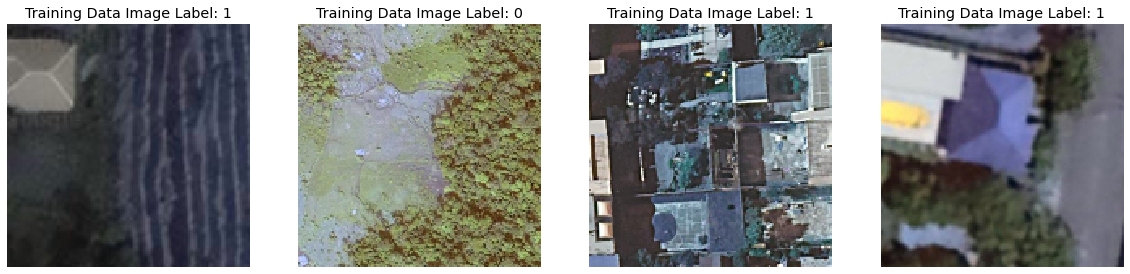

In [28]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,15))
for ax, image, label in zip(axes, X, (y)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training Data Image Label: {label}")  

In [29]:
test_data = np.array(test_data)

In [30]:
random.shuffle(test_data)

testX = []
testy = []

for features, label in test_data:
    testX.append(features)
    testy.append(label)
    
testX = np.array(testX)/255
testy = np.array(testy)
print('X Shape', np.array(testX).shape)
print('y Shape', np.array(testy).shape)

X Shape (44, 150, 150, 3)
y Shape (44,)


In [31]:
testX.shape

(44, 150, 150, 3)

In [32]:
testy.shape

(44,)

In [33]:
np.unique(testy)

array([0, 1, 2, 3])

In [34]:
y_prob = pretrainedmodel.predict(testX)
test_pred = y_prob.argmax(axis=1)

In [35]:
print(len(testy[testy != test_pred]),'cases out of', len(testy), 
      'cases are being misclassified by the pre-trained model which gives us an error rate of', 
      np.around((len(testy[testy != test_pred])/len(testy)*100),3))

1 cases out of 44 cases are being misclassified by the pre-trained model which gives us an error rate of 2.273


In [36]:
confusionmatrix = np.around(confusion_matrix(testy, test_pred, normalize='true'),3)

#Plotting the Confusion Matrix
fig = px.imshow(confusionmatrix, 
                template='ggplot2',
                text_auto=True, 
                aspect="auto", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")

fig.update_yaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)
fig.show()

## Custom Build CNN Architecture

### Assigning Weights to all classes

Since we dont have enough training data hence we would want to have the classifier heavily weight the few examples that are available. We are this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [37]:
class_weight = {}
for i in range(len(np.unique(y))):
    for x in [np.around((len(y[y==i]))/(y.shape[0]),4)]:
        class_weight[i] = x
        
print('=== CLASS WEIGHT ===')
print(class_weight)

=== CLASS WEIGHT ===
{0: 0.2504, 1: 0.2505, 2: 0.2497, 3: 0.2494}


In [38]:
collected = gc.collect()
print("Garbage collector collected", "%d objects." % collected)

Garbage collector collected 13585 objects.


## Splitting the data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape[0], 'Training Images')
print(X_test.shape[0], 'Test Images')

5247 Training Images
1750 Test Images


## Model creation and training

### Model Creation

In [40]:
model = Sequential()

#Input Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding = 'Same', input_shape=(150,150,3))),
model.add(MaxPool2D(pool_size=(2, 2), strides=2)),
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Output Layer
model.add(Flatten())
model.add(Dense(4, activation = "softmax"))

#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        9

### Setting Optimizations

In [41]:
initial_learning_rate = 0.1

lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [42]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy' ])

### Training

In [43]:
history = model.fit(X_train,y_train,batch_size = 500, epochs=100,validation_data = (X_test,y_test),
                    validation_batch_size = 500,verbose=1, class_weight= class_weight, callbacks=callback )

2022-09-19 14:58:57.179180: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1416690000 exceeds 10% of free system memory.


Epoch 1/100
11/11 [==============================] - 7s 441ms/step - loss: 7.5798 - accuracy: 0.4075 - val_loss: 31177.9883 - val_accuracy: 0.2686
Epoch 2/100
11/11 [==============================] - 2s 219ms/step - loss: 1.9422 - accuracy: 0.5466 - val_loss: 4415.2056 - val_accuracy: 0.2680
Epoch 3/100
11/11 [==============================] - 3s 244ms/step - loss: 0.8417 - accuracy: 0.5990 - val_loss: 1695.2964 - val_accuracy: 0.2686
Epoch 4/100
11/11 [==============================] - 2s 214ms/step - loss: 0.4428 - accuracy: 0.6240 - val_loss: 936.4947 - val_accuracy: 0.2686
Epoch 5/100
11/11 [==============================] - 2s 230ms/step - loss: 0.2904 - accuracy: 0.6672 - val_loss: 441.1791 - val_accuracy: 0.2686
Epoch 6/100
11/11 [==============================] - 2s 215ms/step - loss: 0.2338 - accuracy: 0.7071 - val_loss: 321.2211 - val_accuracy: 0.2686
Epoch 7/100
11/11 [==============================] - 2s 211ms/step - loss: 0.3145 - accuracy: 0.6423 - val_loss: 246.3178 - va

## Custom Build Model Performance Evaluation

### Loss Plot

In [44]:
fig = px.line(x=range(len(history.history['loss'])),
             y=history.history['loss'], 
              color_discrete_sequence=["steelblue"],
               
              labels = {'x': 'Epoch', 'y': 'Loss'},
                      template='simple_white',
                      title = ' Training Loss Plot',
                      markers=True)
fig.update_layout(xaxis_title="Epochs", yaxis_title=" Loss")

fig1 = px.line(x=range(len(history.history['val_loss'])),
               y=history.history['val_loss'], template='simple_white',
              labels = {'x': 'Epoch', 'y': 'Validation Loss'},
               color_discrete_sequence=["orange"],
               title = 'Validation Loss Plot', markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title=" Validation Loss")

fig.show()
fig1.show()

### Accuracy Plot

In [45]:
fig = px.line(x = range(len(history.history['accuracy'])),
              y=history.history['accuracy'], 
              template='simple_white',
               
              labels = {'x': 'Epoch', 'y': 'Accuracy'},
              color_discrete_sequence=["steelblue"],
              title = 'Training Accuracy| Plot', 
              #text=[ '%.3f' % elem for elem in history.history['accuracy'] ],
              markers=True)
fig.update_layout(xaxis_title="Epochs", yaxis_title=" Accuracy")
fig.update_traces(textposition="top center")

#2nd Plot
fig1 = px.line(x= range(len(history.history['val_accuracy'])), 
    y= history.history['val_accuracy'], 
               template='simple_white',
              labels = {'x': 'Epoch', 'y': 'Validation Accuracy'},
               title = 'Validation Accuracy Plot', 
               color_discrete_sequence=["orange"],
               markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title="Validation Accuracy")
fig1.update_traces(textposition="top center")

fig.show()
fig1.show()

### Classification Report

In [46]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       470
           1       0.55      0.94      0.69       402
           2       0.90      0.43      0.58       470
           3       0.93      0.77      0.84       408

    accuracy                           0.73      1750
   macro avg       0.79      0.74      0.73      1750
weighted avg       0.79      0.73      0.73      1750



### Misclassification Plot of custom build model

In [47]:
count = {int(value): list(y_test[y_test != y_pred]).count(value) for value in set(y_test[y_test != y_pred])}
maxvalue = max(count, key=count.get)
#Setting the color of the most misqualified labels to 'indianred'
colors = {}
keys = range(len(np.unique(y_train)))
for i in keys:
    for x in ['lightgray']:
        for j in ['indianred']:
            colors[i] = x
            colors[maxvalue] = j
print(colors)

{0: 'lightgray', 2: 'indianred', 1: 'lightgray', 3: 'lightgray'}


In [48]:
fig = px.histogram(x=y_test[y_test != y_pred],
             template='simple_white', 
                   text_auto=True,
             color = y_test[y_test != y_pred],
                   color_discrete_map = colors,
                   labels={"color":"Color"},
             title='Misclassified Labels')

fig.update_layout(xaxis_title="Misclassified Labels",yaxis_title="Count", bargap=0.2)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1, type="category", categoryorder="total descending")

fig.show()

In [49]:
collected = gc.collect()
print("Garbage collector collected", "%d objects." % collected)

Garbage collector collected 6229 objects.


### Misclassification Error Rate

In [50]:
print(len(y_test[y_test != y_pred]),'cases out of', len(y_test), 
      'cases are being misclassified by custom build model which gives us an error rate of', 
      np.around((len(y_test[y_test != y_pred])/len(y_test)*100),3))

467 cases out of 1750 cases are being misclassified by custom build model which gives us an error rate of 26.686


In [51]:
confusionmatrix = np.around(confusion_matrix(y_test, y_pred, normalize='true'),3)

#Plotting the Confusion Matrix
fig = px.imshow(confusionmatrix, 
                template='ggplot2',
                text_auto=True, 
                aspect="auto", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")

fig.update_yaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)

fig.update_xaxes(ticktext=['Farming', 'Housing', 'Industrial', 'Nature'],tickvals=[0,1,2,3], 
                 ticklabelstep=1)
fig.show()

## Saving the Model

In [52]:
pretrainedmodel.save("pretrainedmodel.h5")

1. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data